## 这是一个 Jupyter Notebook，详细展示了如何使用卷积神经网络（CNN）对海洋流场数据进行超分辨率（Super-Resolution, SR）重建, 使用`u_bar` 数据进行模型训练、评估和可视化的完整流程。建议初次使用者从这里开始。

## 流程概览:
- 1.  配置与导入: 集中管理所有路径和超参数。
- 2.  数据准备: 为训练、验证和测试集构建专属的Dataset和DataLoader。
- 3.  模型定义: 构建一个基础的CNN用于超分辨率。
- 4.  工具函数: 定义相对L2误差计算和标准化的可视化函数。
- 5.  训练与验证: 执行模型训练循环，并根据验证集表现保存最佳模型。
- 6.  测试与可视化: 加载最佳模型，在测试集上进行最终评估并生成对比图。
"""

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import time

## 超参数与配置

In [2]:
class Config:
    # --- 数据与保存路径 ---
    # 数据集所在的根目录
    DATA_DIR = "data/u_bar"  
    # 模型和可视化结果的保存目录
    SAVE_DIR = "./sr_cnn_results_ubar_demo"

    # --- 文件名模板 ---
    LQ_TEMPLATE = "ubar_sr_input_{split}.npy"
    GT_TEMPLATE = "ubar_hr_{split}.npy"
    META_FILES = {
        "mask": "mask.npy",
        "lat": "lat.npy",
        "lon": "lon.npy"
    }
    
    # --- 训练参数 ---
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 1  
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # --- 模型参数 ---
    IN_CHANNELS = 1   # u通道
    OUT_CHANNELS = 1
    HIDDEN_DIMS = 64

# 创建保存目录，如果不存在
os.makedirs(Config.SAVE_DIR, exist_ok=True)

## 数据准备

In [3]:
class Dataset(Dataset):
    """
    为海洋超分任务定制的PyTorch Dataset。
    直接加载预先分割好的 low-resolution (lq) 和 high-resolution (gt) 数据。
    """
    def __init__(self, data_dir, lq_filename, gt_filename):
        """
        Args:
            data_dir (str): 数据文件所在的目录。
            lq_filename (str): 低分辨率数据的文件名。
            gt_filename (str): 高分辨率数据的文件名。
        """
        try:
            lq_path = os.path.join(data_dir, lq_filename)
            gt_path = os.path.join(data_dir, gt_filename)
            
            # 加载数据并转换为 float32
            self.lq_data = np.load(lq_path).astype(np.float32)
            self.gt_data = np.load(gt_path).astype(np.float32)

            print(f"成功加载数据: {lq_filename} (shape: {self.lq_data.shape}) 和 {gt_filename} (shape: {self.gt_data.shape})")

        except FileNotFoundError as e:
            raise FileNotFoundError(f"错误: 数据文件未找到。请确保路径 '{data_dir}' 正确且包含所需文件。\n{e}")

    def __len__(self):
        return self.lq_data.shape[0]
    
    def __getitem__(self, idx):
        # 从 (H, W) 扩展为 (C, H, W) 以符合CNN输入要求
        lq_sample = torch.from_numpy(self.lq_data[idx]).unsqueeze(0)
        gt_sample = torch.from_numpy(self.gt_data[idx]).unsqueeze(0)
        
        return {'lq': lq_sample, 'gt': gt_sample}

## CNN 模型定义

In [4]:
class SimpleSRCNN(nn.Module):
    """一个用于超分辨率的基础CNN模型"""
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(SimpleSRCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        """
        前向传播
        Args:
            x (torch.Tensor): 输入的低分辨率图像, shape (B, C_in, H, W)
        Returns:
            torch.Tensor: 输出的超分辨率图像, shape (B, C_out, H, W)
        """
        return self.network(x)


## 工具函数

In [5]:
def calculate_relative_l2_error(pred, gt, mask):
    """
    计算在有效区域（mask内）的相对L2误差。
    公式: ||pred - gt||_2 / ||gt||_2
    
    Args:
        pred (torch.Tensor): 模型的预测结果。
        gt (torch.Tensor): 真实的高分辨率数据。
        mask (torch.Tensor): 布尔掩码，True表示有效计算区域。
        
    Returns:
        float: 计算出的相对L2误差。
    """
    # 确保只在有效区域计算
    pred_masked = pred[mask]
    gt_masked = gt[mask]
    
    error_norm = torch.linalg.norm(pred_masked - gt_masked)
    gt_norm = torch.linalg.norm(gt_masked)
    
    # 防止除以零
    if gt_norm == 0:
        return float('inf') if error_norm > 0 else 0.0
        
    return (error_norm / gt_norm).item()

def plot_results(lq, gt, sr, mask, lon, lat, save_path):
    """
    严谨地可视化lq, gt, sr以及它们与gt之间的误差。
    
    -  颜色方案与示例对齐 (RdBu_r)，前三张图共享色标。
    -  图像设置为正方形长宽比。
    -  除了保存文件，也会显示图像。
    - 五张子图，每张图都有独立的colorbar。
    - 使用经纬度作为坐标轴。
    - 应用mask，将无效区域（陆地）显示为灰色。
    """
    lq = np.squeeze(lq) # 形状变为 (H, W)
    gt = np.squeeze(gt)
    sr = np.squeeze(sr)

    # 将mask外的区域设置为NaN以便于绘图忽略
    lq[~mask] = np.nan
    gt[~mask] = np.nan
    sr[~mask] = np.nan

    error_sr = sr - gt
    error_lq = lq - gt
    error_sr[~mask] = np.nan
    error_lq[~mask] = np.nan

    fig, axes = plt.subplots(1, 5, figsize=(35, 8), dpi=150)
    
    titles = [
        'Low-Resolution Input (LQ)', 'High-Resolution Ground Truth (GT)', 'Super-Resolution Output (SR)',
        'Error (SR - GT)', 'Error (LQ - GT)'
    ]
    data_maps = [lq, gt, sr, error_sr, error_lq]
    
    data_vmin = np.nanmin((lq, gt, sr))
    data_vmax = np.nanmax((lq, gt, sr))
    
    for i, ax in enumerate(axes):
        data = data_maps[i]
        cmap = 'RdBu_r'
        
        # 为数据图和误差图设定不同的颜色范围逻辑
        if 'Error' in titles[i]:
            # 误差图：色条应以0为中心对称
            vmax_abs = np.nanmax(np.abs(data))
            vmin, vmax = -vmax_abs, vmax_abs
        else:
            # 数据图：使用统一的颜色范围
            vmin, vmax = data_vmin, data_vmax
            
        # 使用 pcolormesh 以正确处理经纬度坐标
        im = ax.pcolormesh(lon, lat, data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
        
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=12)
        
        ax.set_title(titles[i], fontsize=16, pad=12)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # 设置背景色为灰色，代表陆地
        ax.set_facecolor('0.75')
        
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout(pad=2.5)
    plt.savefig(save_path)
    print(f"可视化结果已保存至: {save_path}")
    plt.show()
    
    plt.close(fig)

## 训练验证

In [6]:
def train_one_epoch(model, loader, optimizer, criterion, mask_tensor, device):
    model.train()
    total_loss = 0.0
    
    for batch in loader:
        lq, gt = batch['lq'].to(device), batch['gt'].to(device)
        
        optimizer.zero_grad()
        pred = model(lq)
        
        # 只在有效区域计算损失
        # loss = criterion(pred[mask_tensor], gt[mask_tensor])
        expanded_mask = mask_tensor.expand_as(pred).bool()
        loss = criterion(pred[expanded_mask], gt[expanded_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(loader)

def validate(model, loader, criterion, mask_tensor, device):
    model.eval()
    total_loss = 0.0
    total_rel_l2_error = 0.0
    
    with torch.no_grad():
        for batch in loader:
            lq, gt = batch['lq'].to(device), batch['gt'].to(device)
            pred = model(lq)
            
            # 计算损失和指标
            expanded_mask = mask_tensor.expand_as(pred).bool()
            loss = criterion(pred[expanded_mask], gt[expanded_mask])
            rel_l2_error = calculate_relative_l2_error(pred, gt, expanded_mask)
            
            total_loss += loss.item()
            total_rel_l2_error += rel_l2_error
            
    avg_loss = total_loss / len(loader)
    avg_rel_l2_error = total_rel_l2_error / len(loader)
    
    return avg_loss, avg_rel_l2_error

def save_predictions_as_npy(model, loader, mask, save_dir, num_samples=3):
    """
    使用模型对验证集中的样本进行预测，并将指定数量的结果保存为.npy文件。同时保存对应的lq和gt文件
    陆地区域的值将被设置为 NaN。
    """
    print(f"\n--- 正在保存 {num_samples} 个验证集预测结果为 .npy 文件 ---")
    model.eval()
    
    # 创建一个子目录来存放 .npy 文件
    output_dir = os.path.join(save_dir, "validation_npy_predictions")
    os.makedirs(output_dir, exist_ok=True)
    
    saved_count = 0
    with torch.no_grad():
        for batch in loader:
            if saved_count >= num_samples:
                break
                
            lq_tensor = batch['lq'].to(Config.DEVICE)
            gt_tensor = batch['gt'].to(Config.DEVICE) # gt也需要用来保存
            sr_tensor = model(lq_tensor)
            
            # 在一个批次中处理每个样本，直到保存够数量
            for i in range(sr_tensor.shape[0]):
                if saved_count >= num_samples:
                    break
                
                # 获取单个样本，移至CPU并转换为numpy
                lq_np = lq_tensor[i].squeeze().cpu().numpy()
                gt_np = gt_tensor[i].squeeze().cpu().numpy()
                sr_np = sr_tensor[i].squeeze().cpu().numpy()
                
                # 应用mask，将陆地区域设置为 NaN
                lq_np[~mask] = np.nan
                gt_np[~mask] = np.nan
                sr_np[~mask] = np.nan
                
                # 创建文件名（使用虚拟日期）
                date_str = f"2018-01-{saved_count + 1:02d}"
                
                save_path_lq = os.path.join(output_dir, f"{date_str}_lq.npy")
                save_path_gt = os.path.join(output_dir, f"{date_str}_gt.npy")
                save_path_sr = os.path.join(output_dir, f"{date_str}_sr.npy")
                
                np.save(save_path_lq, lq_np)
                np.save(save_path_gt, gt_np)
                np.save(save_path_sr, sr_np)
                # 保存文件
                print(f"  已保存 {date_str} 对应的 lq, gt, sr 文件。")
                
                saved_count += 1
    print("--------------------------------------------------")

## 执行流程

=============== 1. 开始数据加载与准备 ===============
元数据 (mask, lat, lon) 加载成功。
成功加载数据: ubar_sr_input_train.npy (shape: (150, 400, 400)) 和 ubar_hr_train.npy (shape: (150, 400, 400))
成功加载数据: ubar_sr_input_val.npy (shape: (50, 400, 400)) 和 ubar_hr_val.npy (shape: (50, 400, 400))
成功加载数据: ubar_sr_input_test.npy (shape: (50, 400, 400)) 和 ubar_hr_test.npy (shape: (50, 400, 400))

--- 变量形状检查 ---
一个批次的 LQ 数据形状: torch.Size([16, 1, 400, 400])
一个批次的 GT 数据形状: torch.Size([16, 1, 400, 400])
Mask 形状: (400, 400)
Lat 形状: (400, 400)
lon 形状: (400, 400)
---------------------

=============== 2. 初始化模型、损失函数和优化器 ===============
模型已创建并移动到设备: cpu
模型参数量: 75,073

=============== 3. 开始模型训练 ===============
Epoch [01/1] | Train Loss: 0.038668 | Val Loss: 0.022484 | Val Rel L2 Error: 0.8722 | Duration: 38.06s
  -> 验证损失降低，已保存最佳模型至: ./sr_cnn_results_ubar_demo\best_model.pth

=============== 4. 开始最终测试与评估 ===============
加载最佳模型: ./sr_cnn_results_ubar_demo\best_model.pth


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25948\2215657579.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



--- 测试集最终性能 ---
  MSE Loss: 0.022717
  Relative L2 Error: 0.9102
------------------------

=============== 5. 生成可视化结果 ===============


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25948\3537616108.py:77: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(lon, lat, data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')


可视化结果已保存至: ./sr_cnn_results_ubar_demo\test_visualization.png


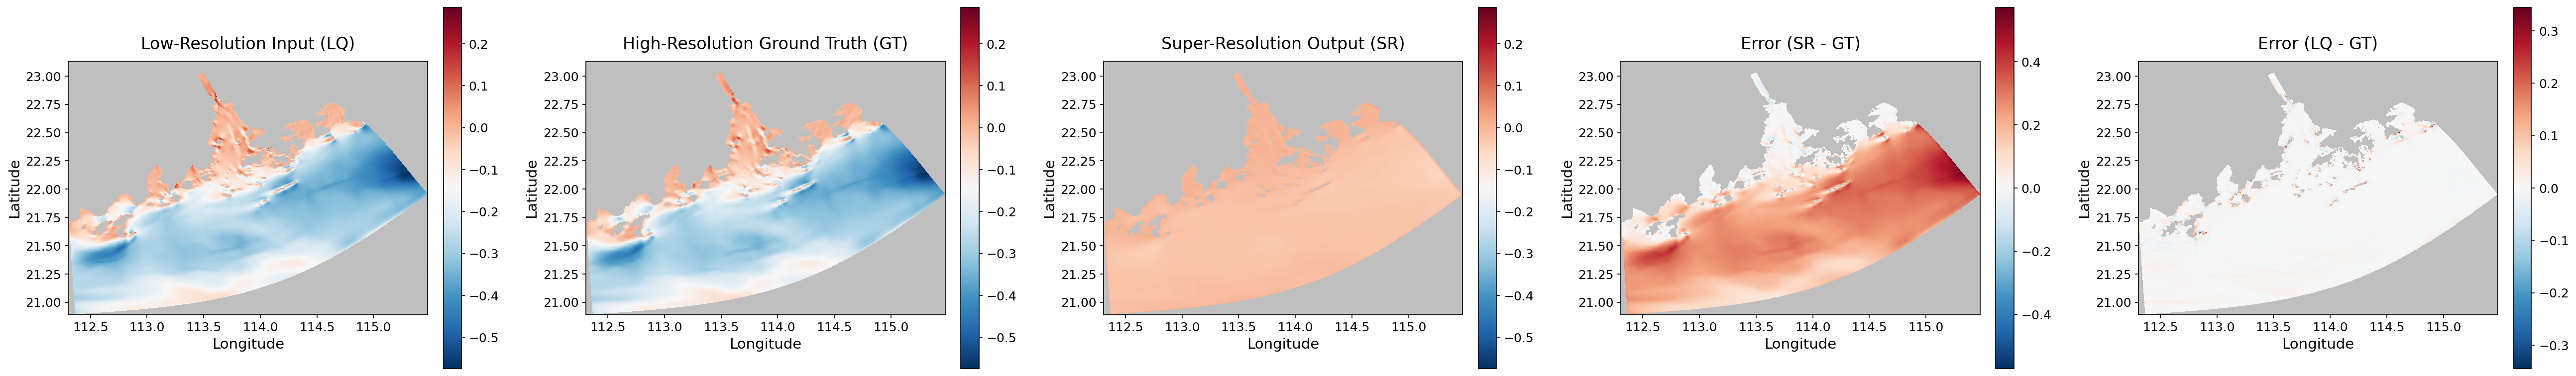


=============== 6. 保存部分验证集预测结果为NPY ===============

--- 正在保存 3 个验证集预测结果为 .npy 文件 ---
  已保存 2018-01-01 对应的 lq, gt, sr 文件。
  已保存 2018-01-02 对应的 lq, gt, sr 文件。
  已保存 2018-01-03 对应的 lq, gt, sr 文件。
--------------------------------------------------

脚本执行完毕。


In [7]:
def main():
    """主函数，执行完整的训练、评估和可视化流程。"""
    
    print("=============== 1. 开始数据加载与准备 ===============")
    
    # --- 加载元数据 ---
    try:
        mask = np.load(os.path.join(Config.DATA_DIR, Config.META_FILES['mask'])).astype(bool)
        lat = np.load(os.path.join(Config.DATA_DIR, Config.META_FILES['lat']))
        lon = np.load(os.path.join(Config.DATA_DIR, Config.META_FILES['lon']))
        print("元数据 (mask, lat, lon) 加载成功。")
    except FileNotFoundError as e:
        print(f"错误: 无法加载元数据。请检查路径 '{Config.DATA_DIR}'。\n{e}")
        return

    # --- 创建 Datasets ---
    train_dataset = Dataset(Config.DATA_DIR, Config.LQ_TEMPLATE.format(split='train'), Config.GT_TEMPLATE.format(split='train'))
    val_dataset = Dataset(Config.DATA_DIR, Config.LQ_TEMPLATE.format(split='val'), Config.GT_TEMPLATE.format(split='val'))
    test_dataset = Dataset(Config.DATA_DIR, Config.LQ_TEMPLATE.format(split='test'), Config.GT_TEMPLATE.format(split='test'))

    # --- 创建 DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # 测试时 batch_size=1 便于可视化

    # --- 形状检查 ---
    print("\n--- 变量形状检查 ---")
    sample_batch = next(iter(train_loader))
    print(f"一个批次的 LQ 数据形状: {sample_batch['lq'].shape}") # 应为 (B, C, H, W)
    print(f"一个批次的 GT 数据形状: {sample_batch['gt'].shape}")
    print(f"Mask 形状: {mask.shape}")
    print(f"Lat 形状: {lat.shape}")
    print(f"lon 形状: {lon.shape}")
    print("---------------------\n")

    
    print("=============== 2. 初始化模型、损失函数和优化器 ===============")
    
    model = SimpleSRCNN(
        in_channels=Config.IN_CHANNELS,
        out_channels=Config.OUT_CHANNELS,
        hidden_dim=Config.HIDDEN_DIMS
    ).to(Config.DEVICE)
    
    print(f"模型已创建并移动到设备: {Config.DEVICE}")
    print(f"模型参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    
    # 准备mask tensor，并扩展维度以匹配数据批次
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).to(Config.DEVICE)
    # 形状变为 (1, 1, H, W)，可以通过广播机制应用于 (B, C, H, W) 的数据

    
    print("\n=============== 3. 开始模型训练 ===============")
    
    best_val_loss = float('inf')
    best_model_path = os.path.join(Config.SAVE_DIR, "best_model.pth")

    for epoch in range(Config.NUM_EPOCHS):
        start_time = time.time()
        
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, mask_tensor, Config.DEVICE)
        val_loss, val_rel_l2 = validate(model, val_loader, criterion, mask_tensor, Config.DEVICE)
        
        epoch_duration = time.time() - start_time
        
        print(
            f"Epoch [{epoch+1:02d}/{Config.NUM_EPOCHS}] | "
            f"Train Loss: {train_loss:.6f} | "
            f"Val Loss: {val_loss:.6f} | "
            f"Val Rel L2 Error: {val_rel_l2:.4f} | "
            f"Duration: {epoch_duration:.2f}s"
        )
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> 验证损失降低，已保存最佳模型至: {best_model_path}")

            
    print("\n=============== 4. 开始最终测试与评估 ===============")
    
    # 加载性能最佳的模型进行测试
    print(f"加载最佳模型: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    
    # 在测试集上进行最终评估
    test_loss, test_rel_l2 = validate(model, DataLoader(test_dataset, batch_size=Config.BATCH_SIZE), criterion, mask_tensor, Config.DEVICE)
    
    print("\n--- 测试集最终性能 ---")
    print(f"  MSE Loss: {test_loss:.6f}")
    print(f"  Relative L2 Error: {test_rel_l2:.4f}")
    print("------------------------\n")
    
    
    print("=============== 5. 生成可视化结果 ===============")
    
    model.eval()
    with torch.no_grad():
        # 从测试集中取一个样本进行可视化
        test_sample = next(iter(test_loader))
        lq_sample = test_sample['lq'].to(Config.DEVICE)
        gt_sample = test_sample['gt'].to(Config.DEVICE)
        
        # 得到模型的超分结果
        sr_sample = model(lq_sample)
        
        # 将数据移回CPU并转为numpy数组用于绘图
        lq_np = lq_sample.cpu().numpy()
        gt_np = gt_sample.cpu().numpy()
        sr_np = sr_sample.cpu().numpy()
        
        vis_save_path = os.path.join(Config.SAVE_DIR, "test_visualization.png")
        plot_results(lq_np, gt_np, sr_np, mask, lon, lat, vis_save_path)
        
    print("\n=============== 6. 保存部分验证集预测结果为NPY ===============")
    save_predictions_as_npy(model, val_loader, mask, Config.SAVE_DIR, num_samples=3)

    print("\n脚本执行完毕。")

if __name__ == '__main__':
    main()